<a href="https://colab.research.google.com/github/PedramDbg/CS-MachineLearning/blob/main/Assignment_3/ML_HW_03_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from  torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchsummary import summary

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
def plot_scores(history, axs):
    acc = [x['val_acc'] for x in history]
    axs.plot(acc, '-o')
    axs.set_xlabel('epoch')
    axs.set_ylabel('acc')
    axs.set_title('Accuracy vs. number of epochs');

def plot_losses(history, axs):
    train_loss = [x.get('train_loss') for x in history]
    val_loss = [x['val_loss'] for x in history]
    axs.plot(train_loss, '-bo', label='Training')
    axs.plot(val_loss, '-go', label='Validation')
    axs.set_xlabel('epoch')
    axs.set_ylabel('loss')
    axs.legend()
    axs.set_title('Loss vs. number of epochs');

# calculate accuracy by counting the number of true predictions and dividing it
# to the whole number of predictions.
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# The decorator defines whether the gradient parameters should be saved or not
# This can reduce the required memory and consequently speed up the computation.

@torch.no_grad() # the decorative decides on saving the model parameters
def evaluate(model, val_loader):
    # instead of training mode, batchnorm or dropout layers will operate in eval mode
    model.eval()
    # determine the loss on the data from the validation set.
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training 
        model.train()
        train_losses = []
        for batch in train_loader:
            # calculate loss on training set
            loss = model.training_step(batch)
            # store losses
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result,lr)
        history.append(result)
    return history

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

class MnistModelBase(torch.nn.Module):
    # calculate the training set's loss
    def training_step(self, batch):
        images, targets = batch   # features and labels
        out = self(images)        # output of the model
        loss = F.cross_entropy(out, targets) 
        return loss  
    
    # calculate the validation set's loss
    def validation_step(self, batch):
        images, targets = batch    # features and labels
        out = self(images)        # output of the model
        loss = F.cross_entropy(out, targets)
        # calculate the accuracy
        acc = accuracy(out, targets)
        # creat a dictionary containing loss and accuracy of validation set
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # stack losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # stack accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result,LR):
        print("Epoch [{}] - LR [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,LR,result['train_loss'], result['val_loss'], result['val_acc']))
        

class MnistModel1(MnistModelBase):
    def __init__(self):
        super().__init__()

        # size: (channel-in, channel-out, kernel size)
        self.conv1 = torch.nn.Conv2d(3, 6, 5, stride=1, padding='same') 
        self.conv2 = torch.nn.Conv2d(6, 16, 5, stride=1, padding='same')
        self.conv3 = torch.nn.Conv2d(16, 120, 5, stride=1, padding='same')

        self.pool = torch.nn.MaxPool2d(2, stride=2)

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(7680, 128)
        self.fc2 = torch.nn.Linear(128, 10)  # 10 classes
        self.softmax = torch.nn.Softmax()

    def forward(self, xb):

        # CNN
        x = self.relu(self.conv1(xb))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))

        # MLP
        x = x.view(x.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
# acquire CIFAR10 dataset

torch.manual_seed(123)

dataset = CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


1. What is the effect of learning rate on the training process? Which performed best? 

Three distinct learning rates (0.01, 0.001 and 0.0001) are used to train the LeNet model in the following.  The accuracy for these three learning rates is displayed in the cell below. The results show that the larger learning rate of 0.01 has the lowest accuracy on the validation set of 0.1. For the epoch number 25, the learning rate of 0.001 provides accuracy around 0.0001. For learning rates of 0.0001, increasing the epoch number from 25 to 40 demonstrates that larger epoch numbers provide greater accuracy.

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size=128      # number of batches
lr = 0.001      # learning rate
epochs = 25     # number of epochs
opt = torch.optim.Adam     # optimizer

train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
# define tensors for training, validation, and test sets
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

torch.Size([3, 32, 32])


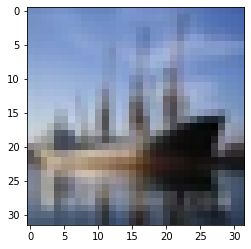

In [ ]:
imgs, lbls = next(iter(train_loader))
print(imgs[123].data.shape)
img = make_grid(imgs[0])
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
device = get_default_device()
# create sets for training, validation, and test
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)


**Problem 1**: What is the effect of learning rate on the training process? Which performed best?**


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             456
              ReLU-2            [-1, 6, 32, 32]               0
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           2,416
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7            [-1, 120, 8, 8]          48,120
              ReLU-8            [-1, 120, 8, 8]               0
            Linear-9                  [-1, 128]         983,168
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 1,035,450
Trainable params: 1,035,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

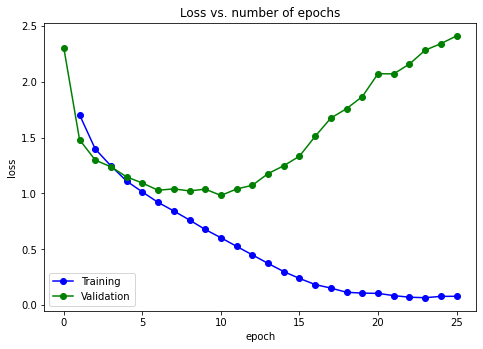

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size=128      # number of batches
lr = 0.001      # learning rate
epochs = 25     # number of epochs
opt = torch.optim.Adam     # optimizer

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])

# training using the created class MnistModel1
model1 = MnistModel1()
to_device(model1, device)
summary(model1, input_size=(3, 32, 32), batch_size=-1)
history1 = [evaluate(model1, val_loader)]
history1 += fit(epochs, lr, model1, train_loader, val_loader, opt)
plot_losses(history1, axs1)
print(history1[-1])


Epoch [0] - LR [0.001], train_loss: 1.6825, val_loss: 1.4265, val_acc: 0.4832
Epoch [1] - LR [0.001], train_loss: 1.3761, val_loss: 1.3243, val_acc: 0.5252
Epoch [2] - LR [0.001], train_loss: 1.2321, val_loss: 1.2073, val_acc: 0.5655
Epoch [3] - LR [0.001], train_loss: 1.1250, val_loss: 1.1158, val_acc: 0.6065
Epoch [4] - LR [0.001], train_loss: 1.0391, val_loss: 1.0915, val_acc: 0.6080
Epoch [5] - LR [0.001], train_loss: 0.9571, val_loss: 1.0559, val_acc: 0.6264
Epoch [6] - LR [0.001], train_loss: 0.8811, val_loss: 1.0426, val_acc: 0.6292
Epoch [7] - LR [0.001], train_loss: 0.8084, val_loss: 0.9740, val_acc: 0.6583
Epoch [8] - LR [0.001], train_loss: 0.7328, val_loss: 0.9700, val_acc: 0.6661
Epoch [9] - LR [0.001], train_loss: 0.6636, val_loss: 1.0045, val_acc: 0.6595
Epoch [10] - LR [0.001], train_loss: 0.5917, val_loss: 1.0253, val_acc: 0.6616
Epoch [11] - LR [0.001], train_loss: 0.5097, val_loss: 1.0646, val_acc: 0.6592
Epoch [12] - LR [0.001], train_loss: 0.4261, val_loss: 1.1171,

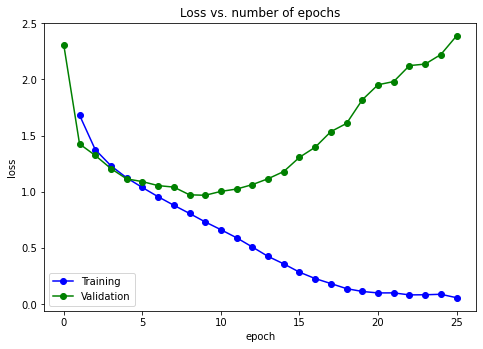

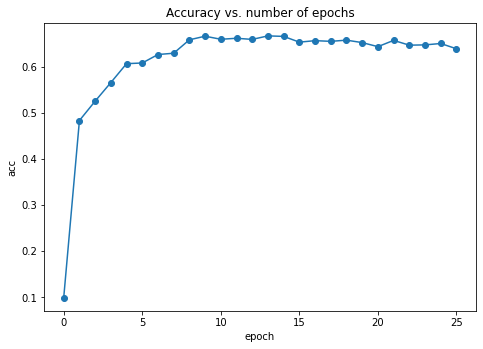

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size=128      # number of batches
lr = 0.001      # learning rate
epochs = 25     # number of epochs
opt = torch.optim.Adam     # optimizer

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

# training using the created class MnistModel1
model2 = MnistModel1()
to_device(model2, device)
history2 = [evaluate(model2, val_loader)]
history2 += fit(epochs, lr, model2, train_loader, val_loader, opt)
plot_losses(history2, axs1)
plot_scores(history2, axs2)
print(history2[-1])

Epoch [0] - LR [0.01], train_loss: 2.3872, val_loss: 2.3029, val_acc: 0.1065
Epoch [1] - LR [0.01], train_loss: 2.3034, val_loss: 2.3037, val_acc: 0.0996
Epoch [2] - LR [0.01], train_loss: 2.3034, val_loss: 2.3027, val_acc: 0.0945
Epoch [3] - LR [0.01], train_loss: 2.3033, val_loss: 2.3044, val_acc: 0.0945
Epoch [4] - LR [0.01], train_loss: 2.3034, val_loss: 2.3025, val_acc: 0.1065
Epoch [5] - LR [0.01], train_loss: 2.3031, val_loss: 2.3036, val_acc: 0.0945
Epoch [6] - LR [0.01], train_loss: 2.3033, val_loss: 2.3029, val_acc: 0.1009
Epoch [7] - LR [0.01], train_loss: 2.3031, val_loss: 2.3027, val_acc: 0.0945
Epoch [8] - LR [0.01], train_loss: 2.3034, val_loss: 2.3038, val_acc: 0.0945
Epoch [9] - LR [0.01], train_loss: 2.3033, val_loss: 2.3034, val_acc: 0.0972
Epoch [10] - LR [0.01], train_loss: 2.3033, val_loss: 2.3029, val_acc: 0.1030
Epoch [11] - LR [0.01], train_loss: 2.3035, val_loss: 2.3035, val_acc: 0.0994
Epoch [12] - LR [0.01], train_loss: 2.3033, val_loss: 2.3030, val_acc: 0.0

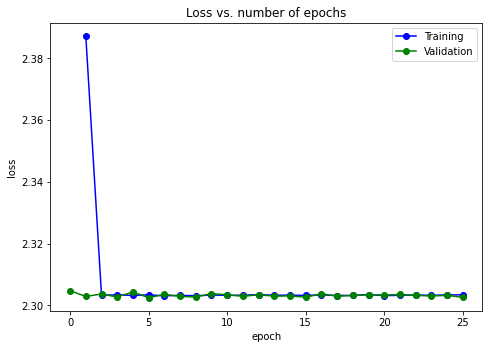

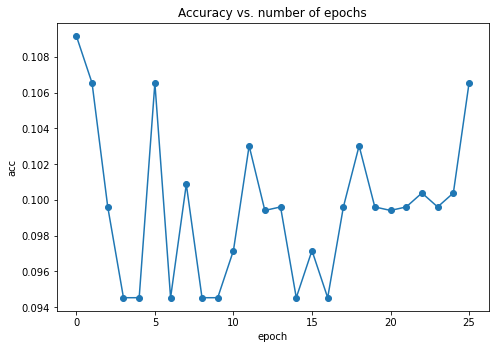

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size=128      # number of batches
lr = 0.01      # learning rate
epochs = 25    # number of epochs
opt = torch.optim.Adam     # optimizer

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

# training using the created class MnistModel1
model3 = MnistModel1()
to_device(model3, device)
history3 = [evaluate(model3, val_loader)]
history3 += fit(epochs, lr, model3, train_loader, val_loader, opt)

plot_losses(history3, axs1)
plot_scores(history3, axs2)
print(history3[-1])


Epoch [0] - LR [0.0001], train_loss: 2.0222, val_loss: 1.7904, val_acc: 0.3545
Epoch [1] - LR [0.0001], train_loss: 1.7374, val_loss: 1.6893, val_acc: 0.3899
Epoch [2] - LR [0.0001], train_loss: 1.6543, val_loss: 1.6173, val_acc: 0.4204
Epoch [3] - LR [0.0001], train_loss: 1.6011, val_loss: 1.5712, val_acc: 0.4446
Epoch [4] - LR [0.0001], train_loss: 1.5611, val_loss: 1.5469, val_acc: 0.4498
Epoch [5] - LR [0.0001], train_loss: 1.5238, val_loss: 1.5134, val_acc: 0.4658
Epoch [6] - LR [0.0001], train_loss: 1.4897, val_loss: 1.4844, val_acc: 0.4763
Epoch [7] - LR [0.0001], train_loss: 1.4558, val_loss: 1.4592, val_acc: 0.4792
Epoch [8] - LR [0.0001], train_loss: 1.4283, val_loss: 1.4317, val_acc: 0.4946
Epoch [9] - LR [0.0001], train_loss: 1.3996, val_loss: 1.4134, val_acc: 0.5019
Epoch [10] - LR [0.0001], train_loss: 1.3725, val_loss: 1.3853, val_acc: 0.5135
Epoch [11] - LR [0.0001], train_loss: 1.3496, val_loss: 1.3710, val_acc: 0.5158
Epoch [12] - LR [0.0001], train_loss: 1.3311, val_

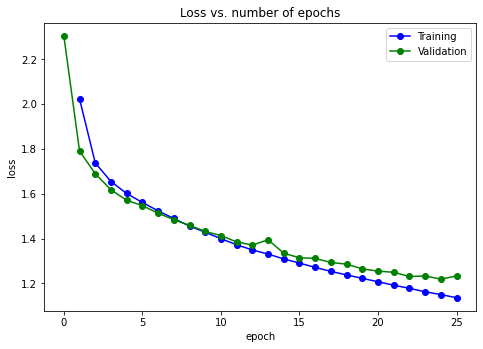

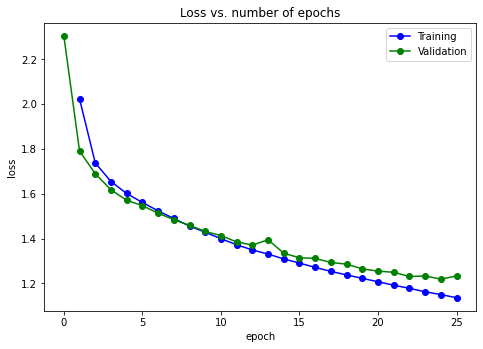

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size = 128      # number of batches
lr = 0.0001      # learning rate
epochs = 25     # number of epochs
opt = torch.optim.Adam     # optimizer

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

# training using the created class MnistModel1
model4 = MnistModel1()
to_device(model4, device)
history4 = [evaluate(model4, val_loader)]
history4 += fit(epochs, lr, model4, train_loader, val_loader, opt)

plot_losses(history4, axs1)
plot_losses(history4, axs2)
print(history4[-1])

Epoch [0] - LR [0.0001], train_loss: 2.0234, val_loss: 1.8243, val_acc: 0.3456
Epoch [1] - LR [0.0001], train_loss: 1.7417, val_loss: 1.6754, val_acc: 0.3888
Epoch [2] - LR [0.0001], train_loss: 1.6325, val_loss: 1.6211, val_acc: 0.4198
Epoch [3] - LR [0.0001], train_loss: 1.5778, val_loss: 1.5581, val_acc: 0.4390
Epoch [4] - LR [0.0001], train_loss: 1.5365, val_loss: 1.5520, val_acc: 0.4406
Epoch [5] - LR [0.0001], train_loss: 1.4994, val_loss: 1.4896, val_acc: 0.4685
Epoch [6] - LR [0.0001], train_loss: 1.4665, val_loss: 1.4542, val_acc: 0.4744
Epoch [7] - LR [0.0001], train_loss: 1.4332, val_loss: 1.4277, val_acc: 0.4931
Epoch [8] - LR [0.0001], train_loss: 1.4032, val_loss: 1.4015, val_acc: 0.4972
Epoch [9] - LR [0.0001], train_loss: 1.3817, val_loss: 1.3910, val_acc: 0.5063
Epoch [10] - LR [0.0001], train_loss: 1.3559, val_loss: 1.3643, val_acc: 0.5098
Epoch [11] - LR [0.0001], train_loss: 1.3339, val_loss: 1.3492, val_acc: 0.5209
Epoch [12] - LR [0.0001], train_loss: 1.3148, val_

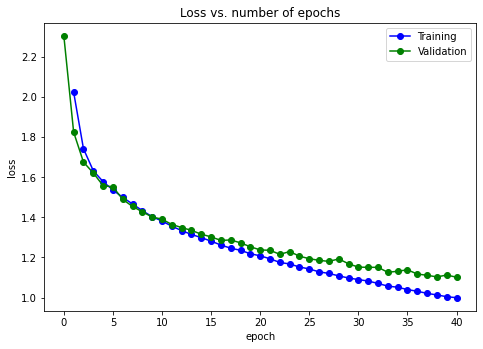

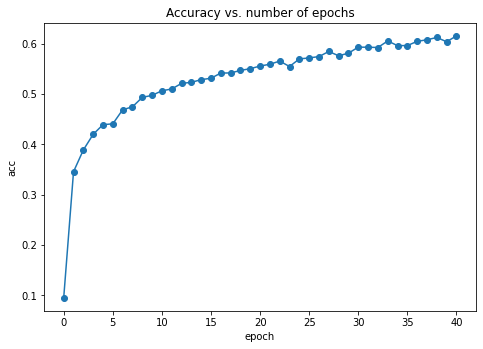

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size=128      # number of batches
lr = 0.0001      # learning rate
epochs = 40     # number of epochs
opt = torch.optim.Adam     # optimizer

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

# training using the created class MnistModel1
model5 = MnistModel1()
to_device(model5, device)
history5 = [evaluate(model5, val_loader)]
history5 += fit(epochs, lr, model5, train_loader, val_loader, opt)
plot_losses(history5, axs1)
plot_scores(history5, axs2)
print(history5[-1])

In [ ]:
print("the report for: epoch:25, lr:0.001", history1[-1])
print("the report for: epoch:25, lr:0.01", history3[-1])
print("the report for: epoch:25, lr:0.0001", history4[-1])
print("the report for: epoch:40, lr:0.0001", history5[-1])


the report for: epoch:25, lr:0.001 {'val_loss': 2.4115936756134033, 'val_acc': 0.6475585699081421, 'train_loss': 0.07867954671382904}
the report for: epoch:25, lr:0.01 {'val_loss': 2.3026480674743652, 'val_acc': 0.10654296725988388, 'train_loss': 2.3034276962280273}
the report for: epoch:25, lr:0.0001 {'val_loss': 1.2333725690841675, 'val_acc': 0.57080078125, 'train_loss': 1.1365418434143066}
the report for: epoch:40, lr:0.0001 {'val_loss': 1.1016404628753662, 'val_acc': 0.6151367425918579, 'train_loss': 0.999524712562561}


**Problem 2**: What is the effect of batch size on the training process? Which performed best?

The best result belongs to the number of batch size equals 512 with 66 percent validation accuracy, but it was not that different from 128 with 65 percent validation accuracy. The least accuracy on the validation set was 61 percent with number of batches of 16. 

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size = 512      # number of batches
lr = 0.001      # learning rate
epochs = 25     # number of epochs
opt = torch.optim.Adam     # optimizer

# define tensors for training, validation, and test sets
train_loader2 = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader2 = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader2 = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

device2 = get_default_device()

# create sets for training, validation, and test
train_loader2 = DeviceDataLoader(train_loader2, device2)
val_loader2 = DeviceDataLoader(val_loader2, device2)
test_loader2 = DeviceDataLoader(test_loader2, device2)

Epoch [0] - LR [0.001], train_loss: 1.9108, val_loss: 1.7355, val_acc: 0.3811
Epoch [1] - LR [0.001], train_loss: 1.6078, val_loss: 1.6080, val_acc: 0.4154
Epoch [2] - LR [0.001], train_loss: 1.4940, val_loss: 1.4686, val_acc: 0.4693
Epoch [3] - LR [0.001], train_loss: 1.4231, val_loss: 1.4350, val_acc: 0.4805
Epoch [4] - LR [0.001], train_loss: 1.3621, val_loss: 1.3561, val_acc: 0.5133
Epoch [5] - LR [0.001], train_loss: 1.3082, val_loss: 1.4047, val_acc: 0.5075
Epoch [6] - LR [0.001], train_loss: 1.2589, val_loss: 1.2707, val_acc: 0.5460
Epoch [7] - LR [0.001], train_loss: 1.2195, val_loss: 1.3381, val_acc: 0.5242
Epoch [8] - LR [0.001], train_loss: 1.1731, val_loss: 1.2110, val_acc: 0.5716
Epoch [9] - LR [0.001], train_loss: 1.1322, val_loss: 1.2156, val_acc: 0.5628
Epoch [10] - LR [0.001], train_loss: 1.1050, val_loss: 1.1813, val_acc: 0.5798
Epoch [11] - LR [0.001], train_loss: 1.0648, val_loss: 1.1655, val_acc: 0.5874
Epoch [12] - LR [0.001], train_loss: 1.0379, val_loss: 1.1327,

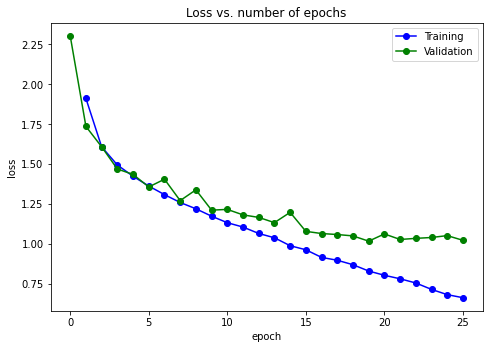

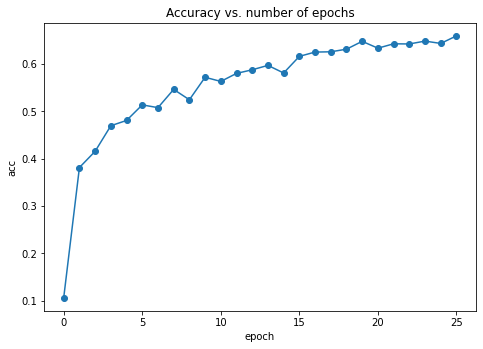

In [ ]:
model6 = MnistModel1()
to_device(model6, device2)

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

history6 = [evaluate(model6, val_loader2)]
history6 += fit(epochs, lr, model6, train_loader2, val_loader2, opt)
plot_losses(history6, axs1)
plot_scores(history6, axs2)
print(history6[-1])

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size = 16      # number of batches
lr = 0.001      # learning rate
epochs = 25     # number of epochs
opt = torch.optim.Adam     # optimizer

# define tensors for training, validation, and test sets
train_loader3 = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader3 = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader3 = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

device3 = get_default_device()

# create sets for training, validation, and test
train_loader3 = DeviceDataLoader(train_loader3, device3)
val_loader3 = DeviceDataLoader(val_loader3, device3)
test_loader3 = DeviceDataLoader(test_loader3, device3)


Epoch [0] - LR [0.001], train_loss: 1.5790, val_loss: 1.3089, val_acc: 0.5304
Epoch [1] - LR [0.001], train_loss: 1.2184, val_loss: 1.2145, val_acc: 0.5747
Epoch [2] - LR [0.001], train_loss: 1.0320, val_loss: 1.0582, val_acc: 0.6298
Epoch [3] - LR [0.001], train_loss: 0.8921, val_loss: 1.0335, val_acc: 0.6448
Epoch [4] - LR [0.001], train_loss: 0.7524, val_loss: 1.0890, val_acc: 0.6329
Epoch [5] - LR [0.001], train_loss: 0.6234, val_loss: 1.0999, val_acc: 0.6481
Epoch [6] - LR [0.001], train_loss: 0.5067, val_loss: 1.2006, val_acc: 0.6426
Epoch [7] - LR [0.001], train_loss: 0.3998, val_loss: 1.3576, val_acc: 0.6553
Epoch [8] - LR [0.001], train_loss: 0.3220, val_loss: 1.5288, val_acc: 0.6467
Epoch [9] - LR [0.001], train_loss: 0.2600, val_loss: 1.8625, val_acc: 0.6298
Epoch [10] - LR [0.001], train_loss: 0.2271, val_loss: 2.0319, val_acc: 0.6093
Epoch [11] - LR [0.001], train_loss: 0.1976, val_loss: 2.0610, val_acc: 0.6265
Epoch [12] - LR [0.001], train_loss: 0.1779, val_loss: 2.1740,

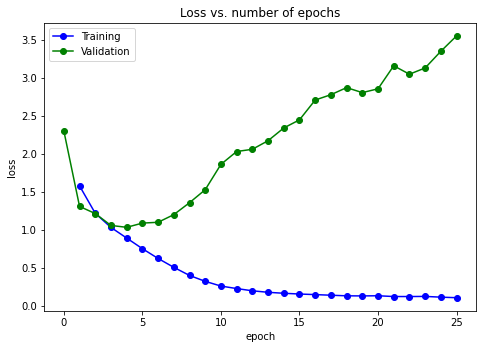

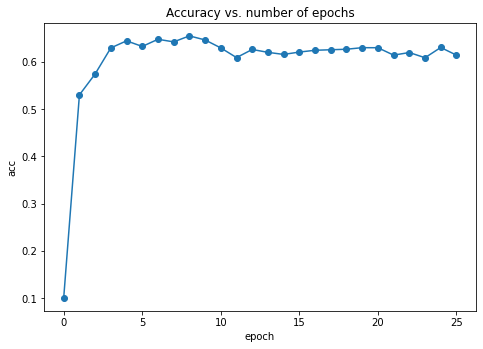

In [ ]:
model7 = MnistModel1()
to_device(model7, device3)

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

history7 = [evaluate(model7, val_loader3)]
history7 += fit(epochs, lr, model7, train_loader3, val_loader3, opt)
plot_losses(history7, axs1)
plot_scores(history7, axs2)
print(history7[-1])

In [ ]:
print("the report for: batch size:128", history1[-1])
print("the report for: batch size:512", history6[-1])
print("the report for: batch size:16", history7[-1])


the report for: batch size:128 {'val_loss': 2.4115936756134033, 'val_acc': 0.6475585699081421, 'train_loss': 0.07867954671382904}
the report for: batch size:512 {'val_loss': 1.0219199657440186, 'val_acc': 0.6589744091033936, 'train_loss': 0.6623289585113525}
the report for: batch size:16 {'val_loss': 3.554412603378296, 'val_acc': 0.6145167946815491, 'train_loss': 0.10655131936073303}


**Problem 3**: Try different hyperparameters to obtain the best accuracy on the test set. What is your best performance and what were the hyperparameters?

Model 3 performed better than model 2. Model 2 and model 3 had the validation accuracy of 70 and 83 percent, respectively.  


In [ ]:
class MnistModel2(MnistModelBase):

    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(0.1),

            torch.nn.Conv2d(16, 16, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(0.1),

            torch.nn.Conv2d(16, 32, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout2d(0.1),
        )

        # translation layer
        self.trans1 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 20, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(20),


            # RF - 14x14
            torch.nn.MaxPool2d(2, 2),
        )

        self.conv2 = torch.nn.Sequential(
            
            torch.nn.Conv2d(20,20,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(20),
            torch.nn.Dropout2d(0.1),

            torch.nn.Conv2d(20,16,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(0.1),

            torch.nn.Conv2d(16, 16, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(0.1),
        ) 

         
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(16,16,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(0.1),
        )   

        # GAP Layer
        self.avg_pool = torch.nn.Sequential(
            # # RF - 22x22
            torch.nn.AvgPool2d(5)
        )   ## output_size=1  

        self.conv4 = torch.nn.Sequential(
  
            torch.nn.Conv2d(16,10,1),

        )  

        
    def forward(self, xb):
        x = self.conv1(xb)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avg_pool(x)
        x = self.conv4(x)

        x = x.view(-1, 10)
        return x

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
         Dropout2d-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 16, 28, 28]           2,320
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 32, 26, 26]           4,640
             ReLU-10           [-1, 32, 26, 26]               0
      BatchNorm2d-11           [-1, 32, 26, 26]              64
        Dropout2d-12           [-1, 32, 26, 26]               0
           Conv2d-13           [-1, 20, 26, 26]             660
             ReLU-14           [-1, 20,

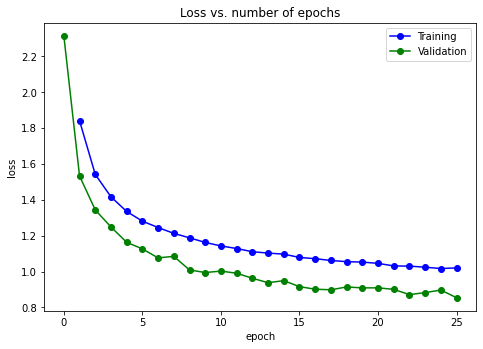

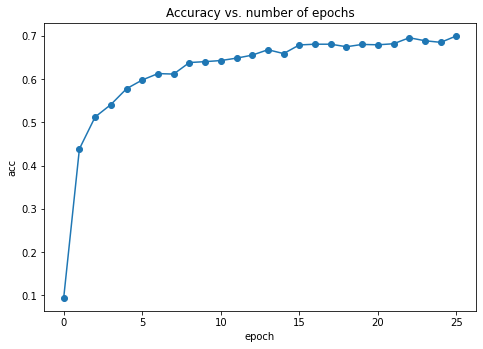

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size = 128      # number of batches
lr = 0.001      # learning rate
epochs = 25     # number of epochs
opt = torch.optim.Adam     # optimizer

model8 = MnistModel2()
to_device(model8, device)

summary(model8, input_size=(3, 32, 32), batch_size=-1)

history8 = [evaluate(model8, val_loader)]
history8 += fit(epochs, lr, model8, train_loader, val_loader, opt)

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

plot_losses(history8, axs1)
plot_scores(history8, axs2)
print(history8[-1])

In [ ]:
class MnistModel3(MnistModelBase):

    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, padding='same', kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),

            torch.nn.Conv2d(32, 32, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Dropout2d(0.2),
        )


        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, padding='same', kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),

            torch.nn.Conv2d(64, 64, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Dropout2d(0.3),
        )


        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, padding='same', kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),

            torch.nn.Conv2d(128, 128, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Dropout2d(0.4),
        )


        self.fc = torch.nn.Sequential(
            torch.nn.Linear(2048, 512),
            torch.nn.Linear(512, 64),
            torch.nn.Linear(64, 10),  # 10 classes
        )

        
    def forward(self, xb):
        x = self.conv1(xb)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
         Dropout2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,928
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1, 64,

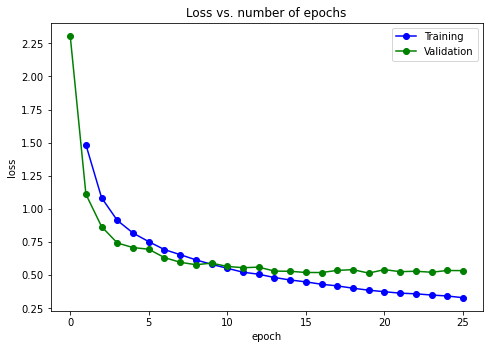

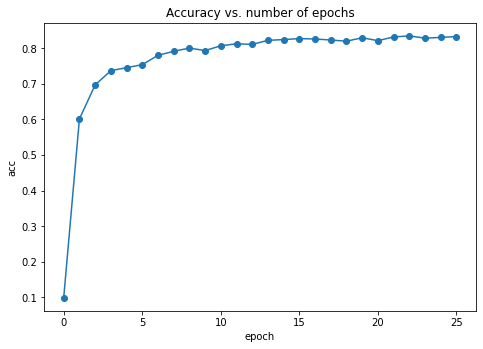

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size = 128      # number of batches
lr = 0.001      # learning rate
epochs = 25     # number of epochs
opt = torch.optim.Adam     # optimizer

model9 = MnistModel3()
to_device(model9, device)

summary(model9, input_size=(3, 32, 32), batch_size=-1)

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

history9 = [evaluate(model9, val_loader)]
history9 += fit(epochs, lr, model9, train_loader, val_loader, opt)
plot_losses(history9, axs1)
plot_scores(history9, axs2)
print(history9[-1])

**Problem 4**: Implement an equivalent feed forward network for the same task with each hidden layer containing the same number of neurons as the number of filters in each convolution layer.
Use the ‘Adam’ optimizer to train your network on the CIFAR-10 dataset for a fixed set of 25 epochs. Compare its performance with your LeNet implementation based on the following questions:

**a. What is its performance?**

The multilayer perceptron's accuracy is approximately $0.38, but the accuracy of the LeNet is approximately $0.65.

**b. How many parameters are there in this network compared to the LeNet
implementation? Are they worth it?**

Number of trainable params in MLP network: $31,604$

Number of trainable params in LeNet network: $1,035,450$


In [ ]:
class CifarModelMLP(MnistModelBase):
    def __init__(self):
        super().__init__()

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(3072, 6)
        self.fc2 = torch.nn.Linear(6, 16)
        self.fc3 = torch.nn.Linear(16, 120)
        self.fc4 = torch.nn.Linear(120, 84)
        self.fc5 = torch.nn.Linear(84, 10)

    def forward(self, xb):

        # MLP
        x = xb.view(xb.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)

        return x

In [ ]:
# define tensors for training, validation, and test sets
train_loader5 = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader5 = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)
test_loader5 = DataLoader(test_dataset, batch_size*2, num_workers=0, pin_memory=True)

device5 = get_default_device()

# create sets for training, validation, and test
train_loader5 = DeviceDataLoader(train_loader5, device5)
val_loader5 = DeviceDataLoader(val_loader5, device5)
test_loader5 = DeviceDataLoader(test_loader5, device5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 6]          18,438
              ReLU-2                    [-1, 6]               0
            Linear-3                   [-1, 16]             112
              ReLU-4                   [-1, 16]               0
            Linear-5                  [-1, 120]           2,040
              ReLU-6                  [-1, 120]               0
            Linear-7                   [-1, 84]          10,164
              ReLU-8                   [-1, 84]               0
            Linear-9                   [-1, 10]             850
Total params: 31,604
Trainable params: 31,604
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.14
---------------------------------------------

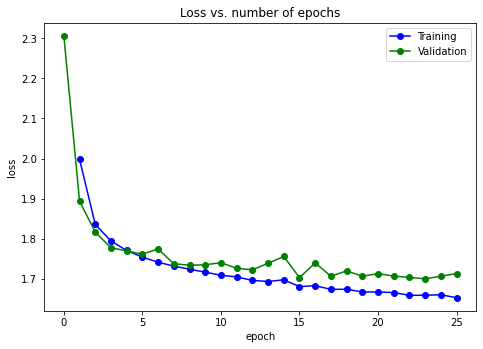

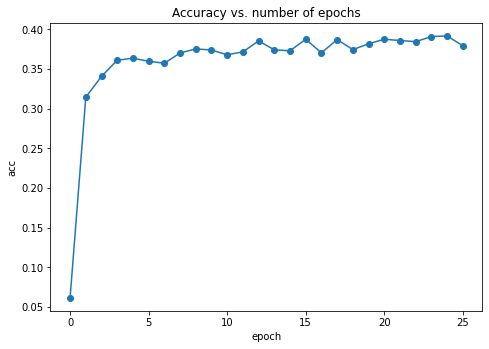

In [ ]:
# define hyper parameters
val_size = 10000    # number of validation instances
batch_size = 128      # number of batches
lr = 0.001      # learning rate
epochs = 25     # number of epochs
opt = torch.optim.Adam     # optimizer

model10 = CifarModelMLP()
to_device(model10, device5)
summary(model10, input_size=(3, 32, 32), batch_size=-1)

fig1 = plt.figure()
axs1 = fig1.add_axes([0,0,1,1])
fig2 = plt.figure()
axs2 = fig2.add_axes([0,0,1,1])

history10 = [evaluate(model10, val_loader5)]
history10 += fit(epochs, lr, model10, train_loader5, val_loader5, opt)
plot_losses(history10, axs1)
plot_scores(history10, axs2)
print(history10[-1])